In [1]:
marker = ['-', '--', '-.',':', '.', 'o', '-', '--','-.',':','.']
point_marker = ['x', 'o', 'v', '^']
mColor = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'r', 'g', 'b', 'c']

from  empir19nrm02.MC import MCVar, MCVectorVar, MCSimulation, DistributionParam, NameUnit
from empir19nrm02.tools import plotHistScales, plotHistGauss
from empir19nrm02.tools.help import label_font_size, save_fig
import numpy as np
import matplotlib.pyplot as plt
import luxpy as lx

N_trials=100000

# A) Make your very first MCS on a high level stage

In [2]:
# define some input data (as MCVar) (parameter: "normal", "uniform" and "triangle")
mc1 = MCVar(name=NameUnit('V1', 'U1'), distribution=DistributionParam(mean=1.,stddev=2., distribution='normal'))
mc2 = MCVar(name=NameUnit('V2', 'U2'), distribution=DistributionParam(mean=2.,stddev=4., distribution='normal'))

# define some output data (as MCVar to make an analysis after the run)
mcOutPlus = MCVar(name=NameUnit('Plus', 'UnitPlus'))
mcOutMinus = MCVar(name=NameUnit('Minus', 'UnitMinus'))

# define an easy model
def model_easy( a, b):
    return a+b, a-b

# arrange the input and output data into arrays
input = [mc1, mc2]
output = [mcOutPlus, mcOutMinus]

# generate an instance of the MCSimulation class and define the number of triasl
sim = MCSimulation(trials=N_trials)

# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)

# generate/load the random numbers
sim.generate()

# calculate the model
sim.calculate_model(model_easy)

# transfer the results into a data base
res_data = sim.get_result_db()
print(res_data)


  Input Unit       Mean     StdDev   Distr       Plus    u(Plus)       Minus   
0    V1   U1 1.00000000 2.00000000  normal 3.00403981 1.99910235 -0.99596019  \
0    V2   U2 2.00000000 4.00000000  normal 2.99211260 3.98560228 -0.99211260   
0   All      0.00000000 0.00000000         2.99615241 4.46330466 -0.98807279   

    u(Minus)  
0 1.99910235  
0 3.98560228  
0 4.45441163  


# Histogram of Input data

Value= [1.004039807957874, 1.9991023544532402] Inteval(95%)= 7.83725391620068 U= 3.91862695810034
Value= [1.9921126029338356, 3.985602275860191] Inteval(95%)= 15.601530655489873 U= 7.800765327744936


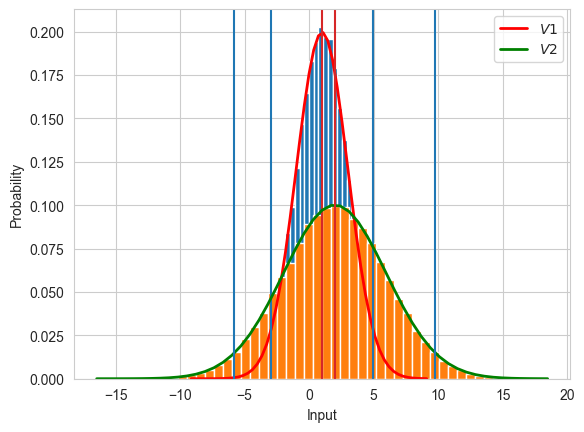

In [3]:
#display some histograms

input_len = len(input)
fig, ax1 = plt.subplots()
for i in range(input_len):
    var = sim.input_var[i]
    plotHistScales( var.val, add_distribution=True, title='', xLabel='Input', density=True, ax=ax1, label='$'+res_data['Input'].values[i]+'$', color=mColor[i])
ax1.legend()
save_fig(dir='test', filename='plus_input' + str(i))

# Histogram of Output data

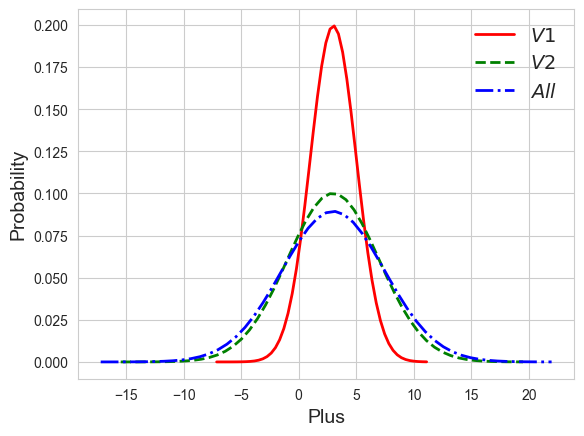

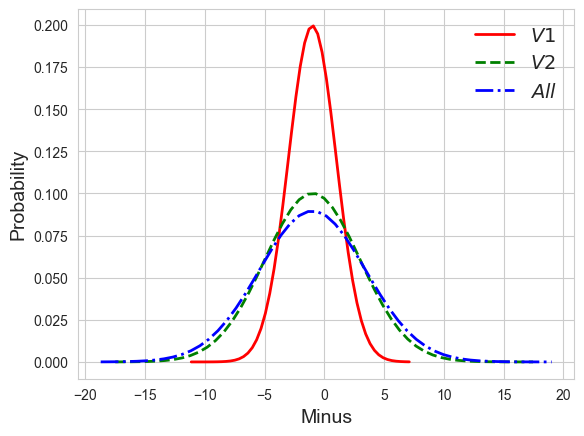

In [4]:
for ii in range(2):
    ax1 = None
    for i in range(input_len+1):
        var = sim.output_var[i]
        ax1 = plotHistGauss( var[ii].val, title='$' + res_data['Input'].values[i] + '$', xLabel=var[ii].name.name, color=mColor[i]+marker[i], relative=False, fontsize=label_font_size, ax=ax1)
    plt.title('')
    save_fig(dir='test', filename='OutHis'+sim.output_var[0][0].name.name)

# B) Luminous intensity excample (photometer)

# $I_{\mathrm{x}}=(d'+\mathrm{\Delta}d_{\mathrm{p}}+\mathrm{\Delta} d_{\mathrm{L}})^2 \cdot (V_{\mathrm{x}} −V_{\mathrm{0}}) \cdot \frac{c \cdot k_{\mathrm{I}}}{R \cdot s_{\mathrm{v}}}$


In [5]:

# define some input data (as MCVar) (parameter: "normal", "uniform" and "triangle")
uni_fact = 1./np.sqrt(3)
mc_distance_meter = MCVar(name=NameUnit('d\prime', 'm'), distribution=DistributionParam(mean=0.1,stddev=0.0002, distribution='normal'))
mc_distance_head = MCVar(name=NameUnit('\Delta d_\mathrm{p}', 'm'), distribution=DistributionParam(mean=0.0,stddev=0.000350*uni_fact, distribution='uniform'))
mc_distance_LED = MCVar(name=NameUnit('\Delta d_\mathrm{L}', 'm'), distribution=DistributionParam(mean=0.0,stddev=0.000170*uni_fact, distribution='uniform'))
mc_indication = MCVar(name=NameUnit('V_\mathrm{x}', 'V'), distribution=DistributionParam(mean=3.0123,stddev=0.0072, distribution='normal'))
mc_indication_dark = MCVar(name=NameUnit('V_\mathrm{0}', 'V'), distribution=DistributionParam(mean=0.0123,stddev=0.0001*uni_fact, distribution='uniform'))
mc_calibration_factor = MCVar(name=NameUnit('c', '1'), distribution=DistributionParam(mean=1,stddev=0.0002, distribution='normal'))
mc_resistance = MCVar(name=NameUnit('R', '\Ohm'), distribution=DistributionParam(mean=1e6,stddev=250, distribution='normal'))
mc_responsivity = MCVar(name=NameUnit('S_\mathrm{v}', 'A/lx'), distribution=DistributionParam(mean=2.95e-9,stddev=1.18e-11, distribution='normal'))
mc_correction = MCVar(name=NameUnit('k_\mathrm{I}', ''), distribution=DistributionParam(mean=1,stddev=6.5e-3, distribution='normal'))

# define some output data (as MCVar to make an analysis after the run)
mc_OutI = MCVar(name=NameUnit('I_\mathrm{x}', 'cd'))
mc_OutIndication = MCVar(name=NameUnit('V\prime', 'V'))

# define an easy model
def model_I(distance_meter, distance_head, distance_LED, indication, indication_dark, calibration_factor, resistance, responsivity, correction):
    Indication = indication-indication_dark
    I = (distance_meter+distance_head+distance_LED)**2*Indication*calibration_factor*correction/(resistance*responsivity)
    return I, Indication

# arrange the input and output data into arrays
input = [mc_distance_meter, mc_distance_head, mc_distance_LED, mc_indication, mc_indication_dark, mc_calibration_factor, mc_resistance, mc_responsivity, mc_correction]
output = [mc_OutI, mc_OutIndication]

# generate an instance of the MCSimulation class and define the number of triasl
sim = MCSimulation(trials=N_trials)

# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)

# generate/load the random numbers
sim.generate()

# calculate the model
sim.calculate_model(model_I)

# transfer the results into a data base
res_data = sim.get_result_db()
print(res_data)
res_data.to_excel('test\BData.xlsx')




                 Input  Unit               Mean       StdDev    Distr   
0              d\prime     m         0.10000000   0.00020000   normal  \
0  \Delta d_\mathrm{p}     m         0.00000000   0.00020207  uniform   
0  \Delta d_\mathrm{L}     m         0.00000000   0.00009815  uniform   
0         V_\mathrm{x}     V         3.01230000   0.00720000   normal   
0         V_\mathrm{0}     V         0.01230000   0.00005774  uniform   
0                    c     1         1.00000000   0.00020000   normal   
0                    R  \Ohm 1,000,000.00000000 250.00000000   normal   
0         S_\mathrm{v}  A/lx         0.00000000   0.00000000   normal   
0         k_\mathrm{I}               1.00000000   0.00650000   normal   
0                  All               0.00000000   0.00000000            

   I_\mathrm{x}  u(I_\mathrm{x})    V\prime  u(V\prime)  
0   10.16938057       0.04073461 3.00000000  0.00000000  
0   10.16960220       0.04107365 3.00000000  0.00000000  
0   10.16954470       

Value= [0.09999925388519423, 0.0002002797449980255] Inteval(95%)= 0.0007837754170022804 U= 0.0003918877085011402


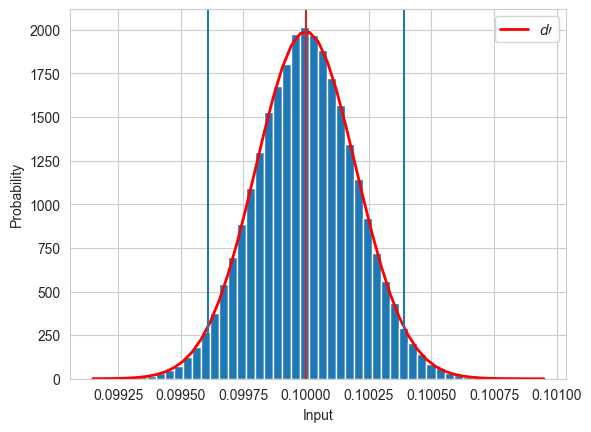

Value= [3.402232731097543e-07, 0.0002019448770046523] Inteval(95%)= 0.0006644599136022488 U= 0.0003322299568011244


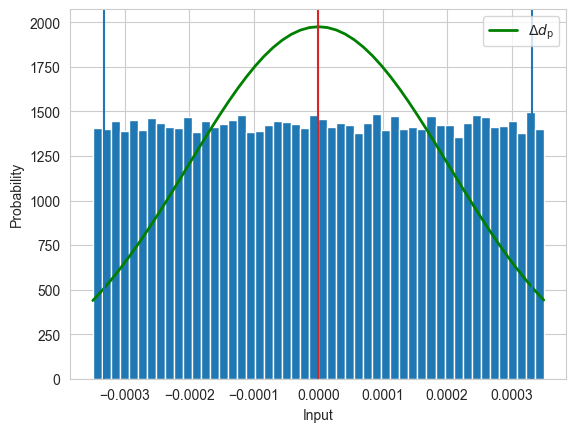

Value= [2.1333246171119313e-07, 9.809792246673949e-05] Inteval(95%)= 0.0003232185010378126 U= 0.0001616092505189063


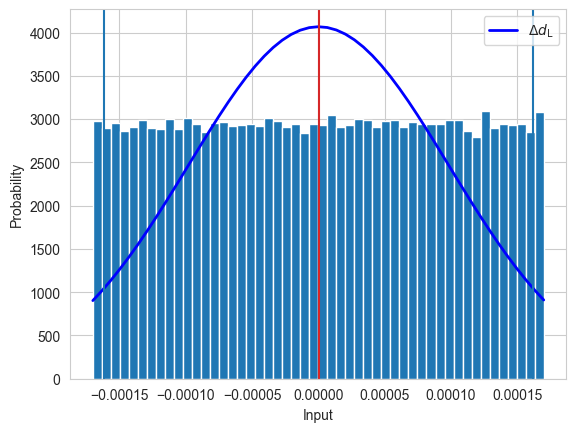

Value= [3.012351963848868, 0.007202825925906747] Inteval(95%)= 0.028191699986882757 U= 0.014095849993441378


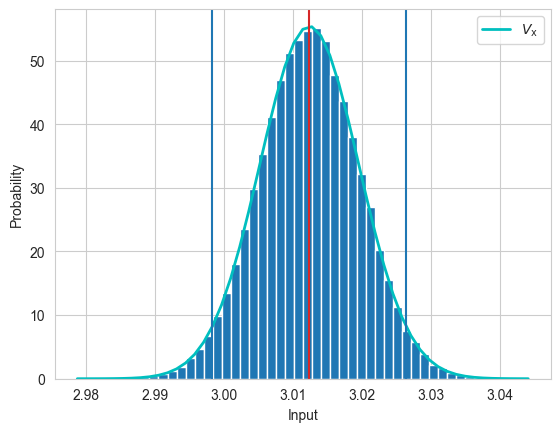

Value= [0.012300038797057884, 5.769697901422396e-05] Inteval(95%)= 0.00018986501752437865 U= 9.493250876218932e-05


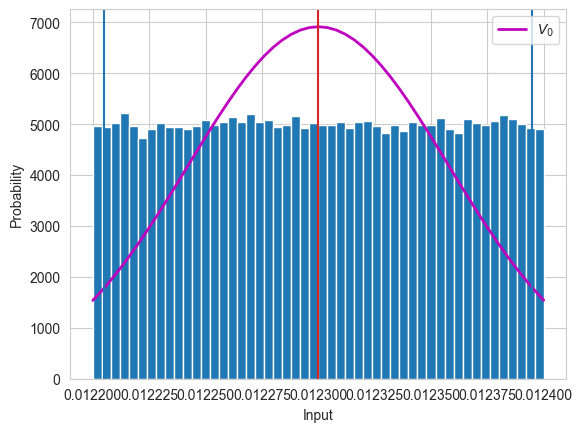

Value= [1.0000006742757201, 0.0002007425765499434] Inteval(95%)= 0.0007876684321802552 U= 0.0003938342160901276


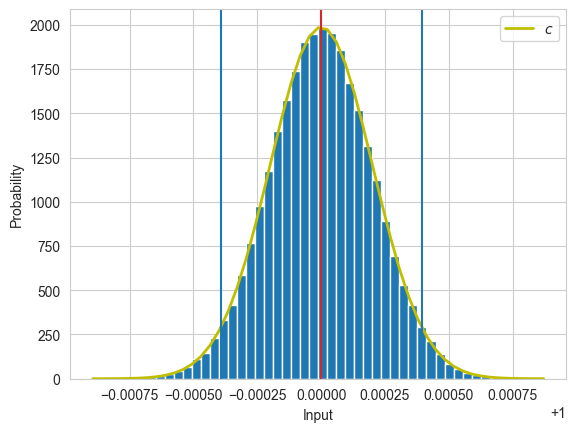

Value= [1000001.4022922665, 250.5629278904903] Inteval(95%)= 981.182584187598 U= 490.591292093799


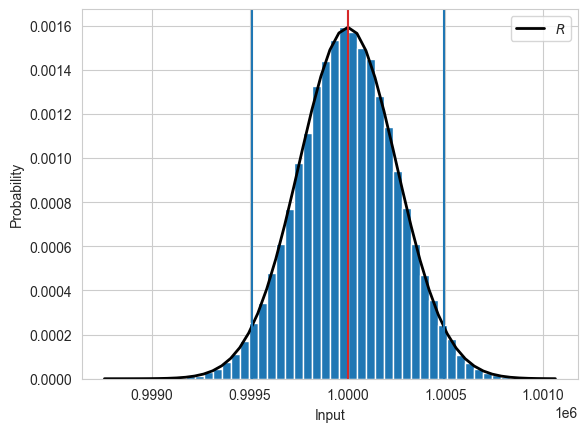

Value= [2.950062145399894e-09, 1.1817923425767559e-11] Inteval(95%)= 4.6128103902582646e-11 U= 2.3064051951291323e-11


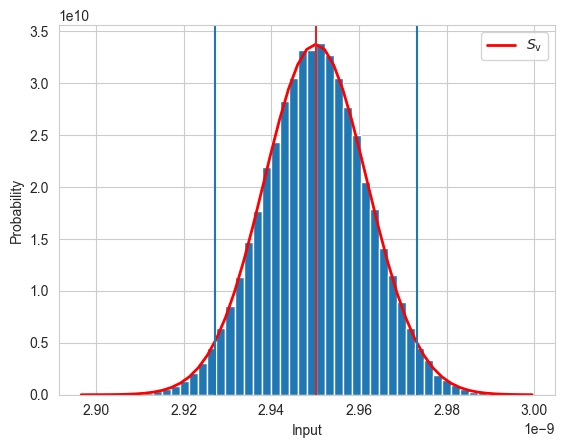

Value= [0.9999987715516786, 0.006507713028015581] Inteval(95%)= 0.02551661957106177 U= 0.012758309785530886


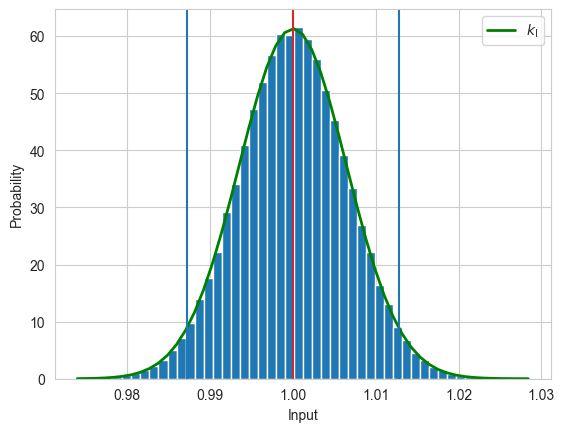

In [6]:
#display some histograms

input_len = len(input)
for i in range(input_len):
    fig, ax1 = plt.subplots()
    var = sim.input_var[i]
    plotHistScales( var.val, add_distribution=True, title='', xLabel='Input', density=True, ax=ax1, label='$'+res_data['Input'].values[i]+'$', color=mColor[i])
    ax1.legend()
    save_fig(dir='test', filename='I_input' + str(i))

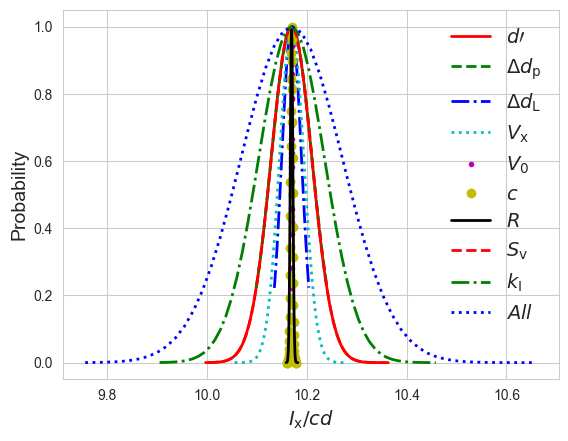

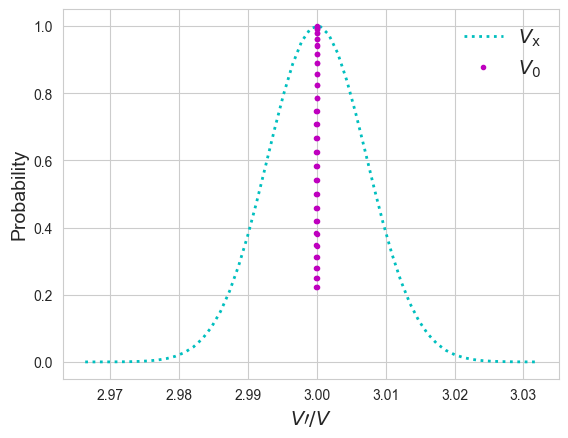

In [7]:
for ii in range(2):
    ax1 = None
    for i in range(input_len+1):
        var = sim.output_var[i]
        if ii==1:
            if 'V' in res_data['Input'].values[i]:
                ax1 = plotHistGauss( var[ii].val, title='$' + res_data['Input'].values[i] + '$', xLabel='$' + var[ii].name.name + '/' + var[ii].name.unit +'$', color=mColor[i]+marker[i], relative=True, fontsize=label_font_size, ax=ax1)
        else:
            ax1 = plotHistGauss( var[ii].val, title='$' + res_data['Input'].values[i] + '$', xLabel='$' + var[ii].name.name + '/' + var[ii].name.unit +'$', color=mColor[i]+marker[i], relative=True, fontsize=label_font_size, ax=ax1)

    plt.title('')
    save_fig(dir='test', filename='BOutHis'+str(ii))

# C) Luminous intensity excample (spectrometer) instead of scalar Values $V_{\mathrm{x}}$ and $V_{\mathrm{0}}$ we use verctor now $\mathbf{V}_{\mathrm{x}}$ and $\mathbf{V}_{\mathrm{0}}$
# $I_{\mathrm{x}}=(d'+\mathrm{\Delta}d_{\mathrm{p}}+\mathrm{\Delta} d_{\mathrm{L}})^2 \cdot \int V(\lambda) \cdot (\mathbf{V}_{\mathrm{x}} −\mathbf{V}_{\mathrm{0}}) \mathrm{d}\lambda \cdot \frac{c \cdot k_{\mathrm{I}}}{R \cdot s_{\mathrm{v}}}$

## integration weighted with $V(\lambda)$
## no wavelength uncertainty

[1.0124e+00 1.0122e+00 1.0120e+00 1.0118e+00 1.0116e+00 1.0114e+00
 1.0113e+00 1.0111e+00 1.0109e+00 1.0107e+00 1.0105e+00 1.0103e+00
 1.0101e+00 1.0099e+00 1.0097e+00 1.0095e+00 1.0094e+00 1.0092e+00
 1.0090e+00 1.0088e+00 1.0087e+00 1.0085e+00 1.0084e+00 1.0082e+00
 1.0081e+00 1.0079e+00 1.0078e+00 1.0077e+00 1.0075e+00 1.0074e+00
 1.0073e+00 1.0072e+00 1.0071e+00 1.0070e+00 1.0069e+00 1.0068e+00
 1.0068e+00 1.0067e+00 1.0066e+00 1.0066e+00 1.0065e+00 1.0065e+00
 1.0065e+00 1.0064e+00 1.0064e+00 1.0064e+00 1.0064e+00 1.0064e+00
 1.0064e+00 1.0065e+00 1.0065e+00 1.0065e+00 1.0066e+00 1.0066e+00
 1.0067e+00 1.0068e+00 1.0068e+00 1.0069e+00 1.0070e+00 1.0071e+00
 1.0072e+00 1.0073e+00 1.0074e+00 1.0075e+00 1.0077e+00 1.0078e+00
 1.0079e+00 1.0081e+00 1.0082e+00 1.0084e+00 1.0085e+00 1.0087e+00
 1.0088e+00 1.0090e+00 1.0092e+00 1.0093e+00 1.0095e+00 1.0097e+00
 1.0099e+00 1.0101e+00 1.0102e+00 1.0104e+00 1.0106e+00 1.0108e+00
 1.0110e+00 1.0112e+00 1.0114e+00 1.0116e+00 1.0117e+00 1.0119

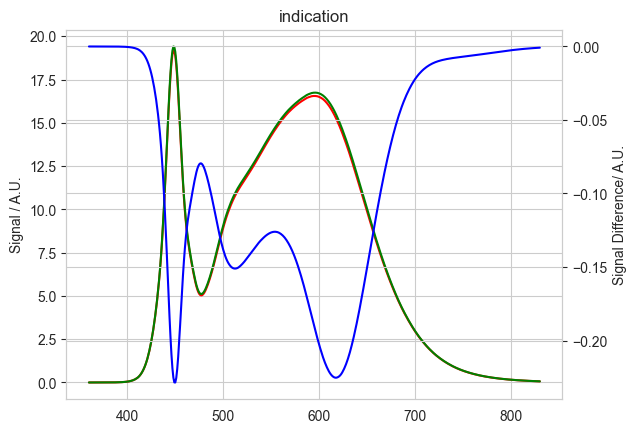

[-1.1447e-03 1.3984e-04 4.8905e-04 -5.0876e-04 -1.1382e-03 -1.8033e-04
 -1.6785e-03 5.9123e-04 1.8656e-04 8.4276e-04 -2.2272e-04 7.2549e-04
 1.4780e-03 1.3199e-03 2.2256e-04 -1.9316e-03 1.0000e-03 3.4950e-04
 1.0748e-03 1.5093e-03 4.1918e-04 -6.7114e-04 3.4784e-05 1.3861e-03
 -7.9795e-05 1.0601e-03 -1.4857e-03 1.1178e-03 -6.9498e-04 9.5510e-04
 1.6496e-03 -1.5794e-04 -5.2942e-04 1.4175e-03 -1.0447e-04 1.7430e-03
 5.3114e-04 1.2135e-03 1.7163e-03 -2.1179e-03 1.5534e-04 -4.3364e-04
 -7.7175e-04 9.8690e-04 -3.5323e-04 2.4236e-04 8.9627e-04 -2.8828e-04
 -1.1338e-04 1.4467e-03 -1.1769e-03 -2.3558e-03 -2.5382e-04 3.2440e-05
 -5.6766e-05 9.1895e-04 4.4327e-04 7.5499e-04 -5.0165e-04 2.0661e-04
 -7.2487e-04 1.7801e-03 -8.2254e-04 2.3943e-03 7.3453e-04 2.7069e-04
 -2.8497e-04 -5.4949e-04 -1.0869e-03 7.1273e-04 -1.8839e-03 -1.5486e-03
 -7.2760e-04 -4.5832e-04 -5.8475e-04 -1.2952e-04 5.2561e-04 -5.7788e-04
 3.7493e-04 -1.7702e-04 1.3121e-03 1.1858e-03 9.2396e-04 -1.2912e-03
 -6.4740e-04 -9.8924e-0

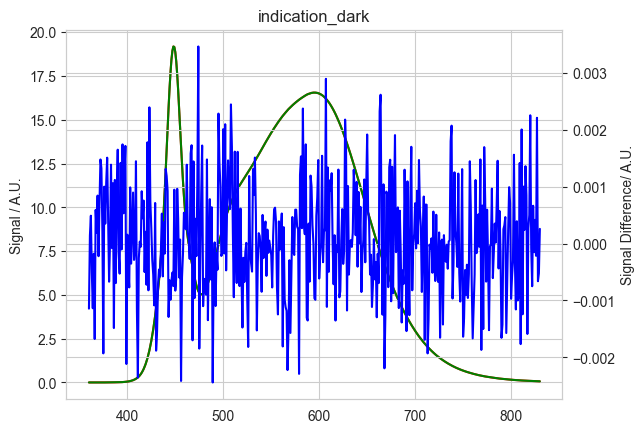

                     Input  Unit               Mean       StdDev       Distr   
0                  d\prime     m         0.10000000   0.00020000      normal  \
0      \Delta d_\mathrm{p}     m         0.00000000   0.00020207     uniform   
0      \Delta d_\mathrm{L}     m         0.00000000   0.00009815     uniform   
0    \mathbf{V}_\mathrm{x}     V         1.00000000   0.00720000  normal f 3   
0  $\mathbf{V}_\mathrm{0}$     V         0.00000000   0.00100000      normal   
0                        c     1         1.00000000   0.00020000      normal   
0                        R  \Ohm 1,000,000.00000000 250.00000000      normal   
0             S_\mathrm{v}  A/lx         0.00000000   0.00000000      normal   
0             k_\mathrm{I}               1.00000000   0.00650000      normal   
0                      All               0.00000000   0.00000000               

   I_\mathrm{x}  u(I_\mathrm{x})    V\prime  u(V\prime)  
0   10.21122027       0.04081173 3.01230000  0.00000000  
0  

In [8]:

# define some input data (as MCVar) (parameter: "normal", "uniform" and "triangle")
wl = lx.getwlr([360,830,1])
len_wl = len(wl)
N_Fourier = 'f 3'

uni_fact = 1./np.sqrt(3)
mc_distance_meter = MCVar(name=NameUnit('d\prime', 'm'), distribution=DistributionParam(mean=0.1,stddev=0.0002, distribution='normal'))
mc_distance_head = MCVar(name=NameUnit('\Delta d_\mathrm{p}', 'm'), distribution=DistributionParam(mean=0.0,stddev=0.000350*uni_fact, distribution='uniform'))
mc_distance_LED = MCVar(name=NameUnit('\Delta d_\mathrm{L}', 'm'), distribution=DistributionParam(mean=0.0,stddev=0.000170*uni_fact, distribution='uniform'))
mcV_indication = MCVectorVar(name=NameUnit('\mathbf{V}_\mathrm{x}', 'V'), elements=len(wl), noise_list={ 'f_mul': DistributionParam(mean = 1., stddev = 0.0072, distribution = 'normal', add_params = N_Fourier)})
mcV_indication.set_vector_param( np.ones(len(wl)), 0.01*np.ones(len(wl)))

mcV_indication_dark = MCVectorVar(name=NameUnit('$\mathbf{V}_\mathrm{0}$', 'V'), elements=len(wl), noise_list={ 'nc_add': DistributionParam(mean = 0, stddev = 0.001, distribution = 'normal')})
mcV_indication_dark.set_vector_param( np.zeros(len(wl)), 0.01*np.ones(len(wl)))

mc_calibration_factor = MCVar(name=NameUnit('c', '1'), distribution=DistributionParam(mean=1,stddev=0.0002, distribution='normal'))
mc_resistance = MCVar(name=NameUnit('R', '\Ohm'), distribution=DistributionParam(mean=1e6,stddev=250, distribution='normal'))
mc_responsivity = MCVar(name=NameUnit('S_\mathrm{v}', 'A/lx'), distribution=DistributionParam(mean=2.95e-9,stddev=1.18e-11, distribution='normal'))
mc_correction = MCVar(name=NameUnit('k_\mathrm{I}', ''), distribution=DistributionParam(mean=1,stddev=6.5e-3, distribution='normal'))

# define some output data (as MCVar to make an analysis after the run)
mc_OutI = MCVar(name=NameUnit('I_\mathrm{x}', 'cd'))
mc_OutIndication = MCVar(name=NameUnit('V\prime', 'V'))

SD_L41 =lx.cie_interp(lx._CIE_ILLUMINANTS['LED_L41'], wl_new = wl, kind= 'S')
fakt_I = 3.0123/lx.spd_to_xyz(SD_L41, relative=False)[0][1]

def plot_SDSpecial(SD_L41, SD_L41_mod):
        fig, ax1 = plt.subplots()
        ax1.plot( SD_L41[0], SD_L41[1], 'r', label='L41 Org')
        ax1.plot( SD_L41_mod[0], SD_L41_mod[1], 'g', label='L41 Mod')
        ax2 = ax1.twinx()
        ax2.plot( SD_L41_mod[0], SD_L41[1] - SD_L41_mod[1], 'b', label='L41 Org - Mod')
        plt.xlabel('Wavelength $\mathbf{\lambda}$ / nm')
        ax1.set_ylabel('Signal / A.U.')
        ax2.set_ylabel('Signal Difference/ A.U.')

b_firstS = True
b_firstD = True
# define an easy model
def model_ISpectrometer(distance_meter, distance_head, distance_LED, indication, indication_dark, calibration_factor, resistance, responsivity, correction):
    global b_firstS
    global b_firstD
    SD_L41_mod = SD_L41.copy()
    SD_L41_mod[0] = wl
    SD_L41_mod[1] *= indication
    SD_L41_mod[1] = SD_L41_mod[1] - indication_dark

    XYZ = lx.spd_to_xyz(SD_L41_mod, relative=False)
    IndicationIntegral = fakt_I*XYZ[0][1]

    if indication[0] != 1 and b_firstS is True:
        b_firstS = False
        print( indication)
        plot_SDSpecial(SD_L41, SD_L41_mod)
        plt.title('indication')
        save_fig(dir='test', filename='indication')
    if indication_dark[0] != 0 and b_firstD is True:
        b_firstD = False
        print( indication_dark)
        plot_SDSpecial(SD_L41, SD_L41_mod)
        plt.title('indication_dark')
        save_fig(dir='test', filename='indication_dark')

    I = (distance_meter+distance_head+distance_LED)**2*IndicationIntegral*calibration_factor*correction/(resistance*responsivity)
    return I, IndicationIntegral

# arrange the input and output data into arrays
input = [mc_distance_meter, mc_distance_head, mc_distance_LED, mcV_indication, mcV_indication_dark, mc_calibration_factor, mc_resistance, mc_responsivity, mc_correction]
output = [mc_OutI, mc_OutIndication]

# generate an instance of the MCSimulation class and define the number of triasl
sim = MCSimulation(trials=N_trials)

# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)

# generate/load the random numbers
sim.generate()

# calculate the model
sim.calculate_model(model_ISpectrometer)

# transfer the results into a data base
res_data = sim.get_result_db()
print(res_data)
res_data.to_excel('test\CData.xlsx')
